In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [21]:
# Load and clean data
df = pd.read_csv("tweets.csv", parse_dates=['time'], infer_datetime_format=True)
df.drop_duplicates(inplace=True)

C:\Users\khush\AppData\Local\Temp\ipykernel_22416\1126997362.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("tweets.csv", parse_dates=['time'], infer_datetime_format=True)


          followers  numberstatuses
count  17410.000000    17410.000000
mean    3975.076680     4760.787651
std     8674.378495     7015.967275
min       16.000000        1.000000
25%      266.000000      207.000000
50%      928.000000      908.000000
75%     1791.000000     6865.000000
max    34692.000000    33091.000000

Missing values:
 name                 0
username             0
description       2682
location          5978
followers            0
numberstatuses       0
time                 0
tweets               0
dtype: int64


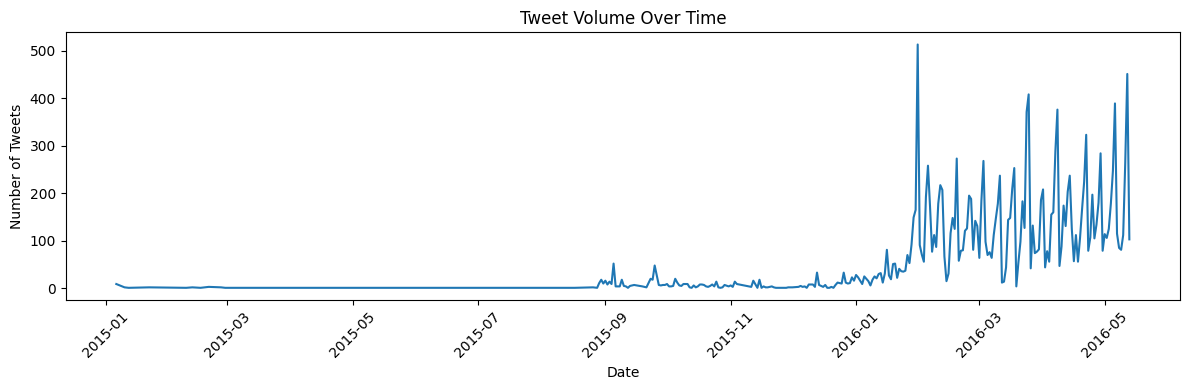

In [22]:
# Summary statistics
print(df[['followers', 'numberstatuses']].describe())
print("\nMissing values:\n", df.isnull().sum())

# Tweet timeline distribution
plt.figure(figsize=(12, 4))
df['time'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title("Tweet Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Top 10 users by followers:
               username  followers
17010      RamiAlLolah      34692
15776         warrnews       7566
17346      Nidalgazaui       4662
9581   Freedom_speech2       3233
17248     WarReporter1       2632
12315    NaseemAhmed50       2230
3281        MaghrebiQM       2021
16148    Uncle_SamCoco       1809
7678       klakishinki       1791
8265      _IshfaqAhmad       1667


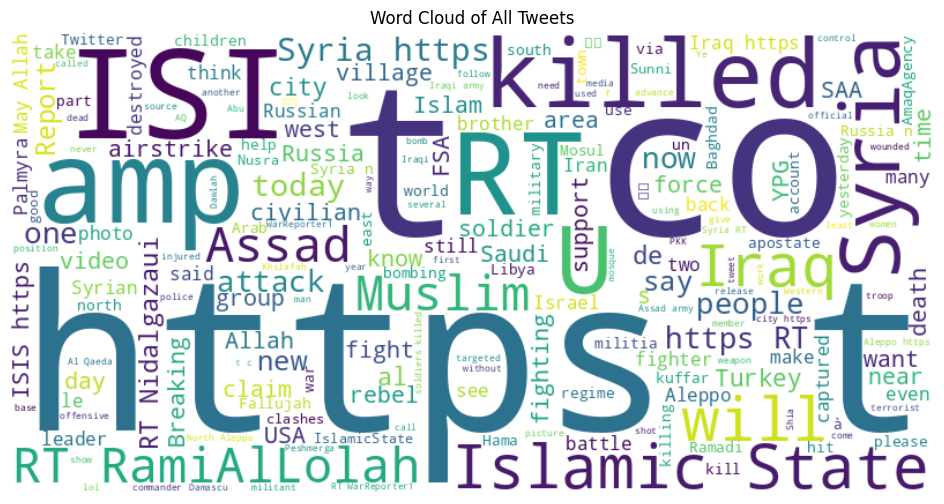

In [23]:
# Top 10 users by followers
top_followed = df[['username', 'followers']].sort_values(by='followers', ascending=False).drop_duplicates('username').head(10)
print("\nTop 10 users by followers:\n", top_followed)

# WordCloud of tweets
text = ' '.join(df['tweets'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Tweets")
plt.show()

Keyword Frequencies:
wilayat: 172
amaq: 90
dabiq: 31
baqiyah: 26


C:\Users\khush\AppData\Local\Temp\ipykernel_22416\1183389433.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()), palette='Reds')


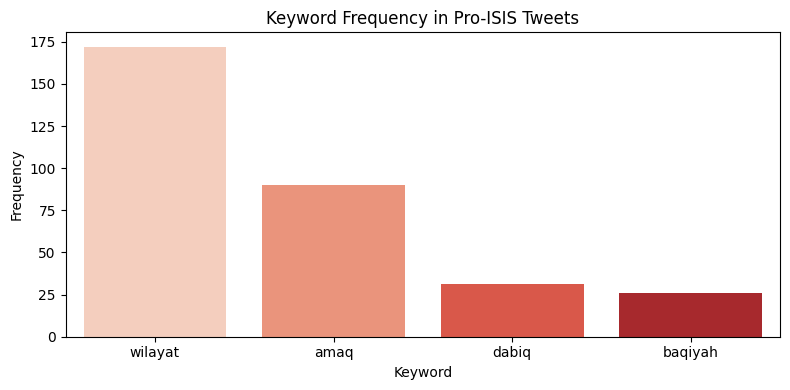

In [24]:
from collections import Counter
import re

# Combine relevant text columns into one for keyword scanning
combined_text = (
    df['tweets'].astype(str) + ' ' +
    df['name'].astype(str) + ' ' +
    df['username'].astype(str) + ' ' +
    df['description'].astype(str) + ' ' +
    df['location'].astype(str)
).str.lower()

# Define keywords to track
keywords = ['baqiyah', 'dabiq', 'wilayat', 'amaq']

# Count keyword frequencies
keyword_counts = {key: combined_text.str.count(r'\b' + re.escape(key) + r'\b').sum() for key in keywords}
keyword_counts = dict(sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True))

# Display counts
print("Keyword Frequencies:")
for k, v in keyword_counts.items():
    print(f"{k}: {v}")

# Bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()), palette='Reds')
plt.title("Keyword Frequency in Pro-ISIS Tweets")
plt.ylabel("Frequency")
plt.xlabel("Keyword")
plt.tight_layout()
plt.show()

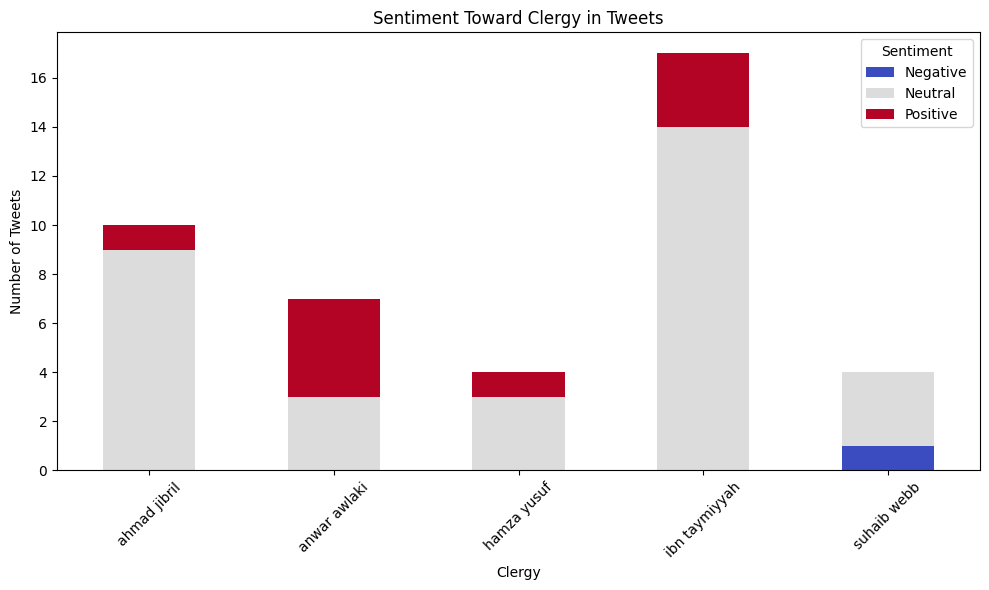

In [25]:
from textblob import TextBlob

# Combine tweets into lowercase
tweets = df['tweets'].astype(str).str.lower()

# Clergy groups
liked_clergy = ['anwar awlaki', 'ahmad jibril', 'ibn taymiyyah', 'abdul wahhab']
disliked_clergy = ['hamza yusuf', 'suhaib webb', 'yaser qadhi', 'nouman ali khan', 'yaqoubi']
all_clergy = liked_clergy + disliked_clergy

# Extract mentions and sentiment
results = []

for tweet in tweets:
    for name in all_clergy:
        if name in tweet:
            sentiment = TextBlob(tweet).sentiment.polarity
            if sentiment > 0.1:
                sentiment_label = 'Positive'
            elif sentiment < -0.1:
                sentiment_label = 'Negative'
            else:
                sentiment_label = 'Neutral'
            results.append((name, sentiment_label))

# Create DataFrame of results
sentiment_df = pd.DataFrame(results, columns=['Clergy', 'Sentiment'])

# Count sentiment per clergy
sentiment_summary = sentiment_df.groupby(['Clergy', 'Sentiment']).size().unstack(fill_value=0)

# Plot
sentiment_summary.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))
plt.title("Sentiment Toward Clergy in Tweets")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\khush\AppData\Local\Temp\ipykernel_22416\697371185.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="Blues_r")


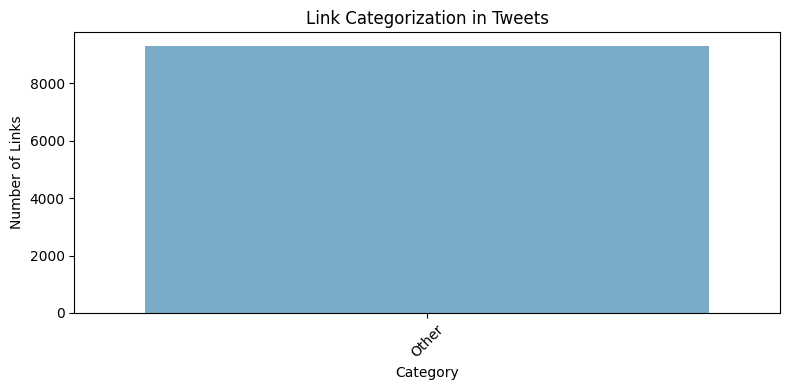

In [26]:
import re
from urllib.parse import urlparse

# Extract all links from tweets
links = df['tweets'].str.extractall(r'(https?://[^\s]+)')[0]

# Clean and parse domain names
domains = links.dropna().apply(lambda url: urlparse(url).netloc.lower())

# Define domain categories
categories = {
    'Mainstream Media': ['cnn.com', 'bbc.com', 'reuters.com', 'nytimes.com', 'foxnews.com'],
    'Altermedia': ['globalresearch.ca', 'infowars.com', 'veteranstoday.com'],
    'Jihadist Websites': ['justpaste.it', 'alplatformmedia.com', 'archive.org'],
    'Image Upload': ['imgur.com', 'tinypic.com'],
    'Video Upload': ['youtube.com', 'vimeo.com', 'dailymotion.com']
}

# Categorize domains
def categorize(domain):
    for category, domain_list in categories.items():
        if any(d in domain for d in domain_list):
            return category
    return 'Other'

domain_categories = domains.apply(categorize)
category_counts = domain_categories.value_counts()

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="Blues_r")
plt.title("Link Categorization in Tweets")
plt.ylabel("Number of Links")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
# Extract and clean domains
links = df['tweets'].str.extractall(r'(https?://[^\s]+)')[0]
domains = links.dropna().apply(lambda url: urlparse(url).netloc.lower())

# Display top 30 actual domains in the tweets
top_domains = domains.value_counts().head(30)
print("Top 30 domains:\n")
print(top_domains)


Top 30 domains:

0
t.co     8647
…         183
t…        151
t.…       136
t.c…      110
t.co…      73
Name: count, dtype: int64


In [9]:
# Extract t.co links
tco_links = links[links.str.contains("t.co", na=False)].dropna().unique()

# Save to CSV
pd.DataFrame(tco_links, columns=['shortened_url']).to_csv("tco_links_to_expand.csv", index=False)

print("Saved all t.co links to 'tco_links_to_expand.csv'. You can now expand them externally.")


Saved all t.co links to 'tco_links_to_expand.csv'. You can now expand them externally.


In [28]:
import pandas as pd

df = pd.read_csv("tweets.csv")
print(df.columns)


Index(['name', 'username', 'description', 'location', 'followers',
       'numberstatuses', 'time', 'tweets'],
      dtype='object')


C:\Users\khush\AppData\Local\Temp\ipykernel_22416\2967048813.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\khush\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


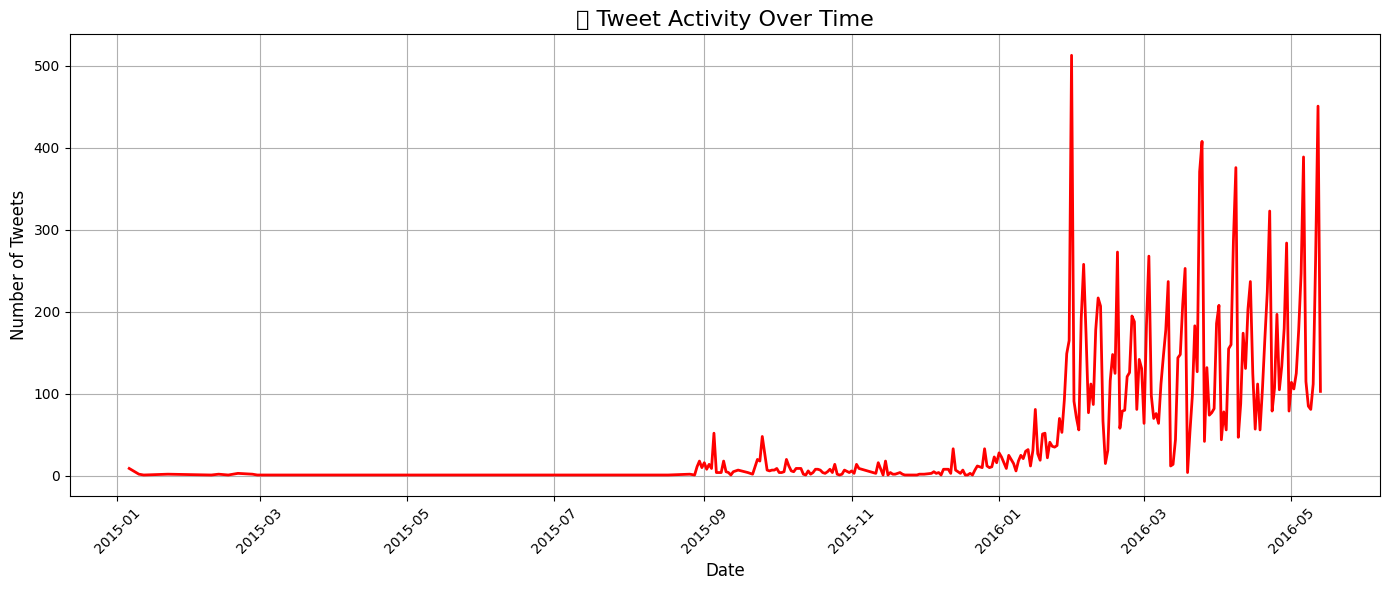

In [29]:
import matplotlib.pyplot as plt

# Ensure 'datetime' column is in datetime format
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Drop rows with invalid datetime
df = df.dropna(subset=['time'])

# Group tweets by day
tweets_by_date = df['time'].dt.date.value_counts().sort_index()

# Plot the tweet timeline
plt.figure(figsize=(14, 6))
plt.plot(tweets_by_date.index, tweets_by_date.values, color='red', linewidth=2)
plt.title("📈 Tweet Activity Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [37]:
#import 

tweets = pd.read_csv('tweets.csv')
print(tweets.head())
print()
print(tweets.describe())

            name         username  \
0  GunsandCoffee  GunsandCoffee70   
1  GunsandCoffee  GunsandCoffee70   
2  GunsandCoffee  GunsandCoffee70   
3  GunsandCoffee  GunsandCoffee70   
4  GunsandCoffee  GunsandCoffee70   

                                    description location  followers  \
0  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
1  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
2  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
3  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   
4  ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews      NaN        640   

   numberstatuses            time  \
0              49  1/6/2015 21:07   
1              49  1/6/2015 21:27   
2              49  1/6/2015 21:29   
3              49  1/6/2015 21:37   
4              49  1/6/2015 21:45   

                                              tweets  
0  ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...  
1  ENGLISH TRANSL

In [39]:

def preprocess(tweet):

    
    tweet = re.sub(r'ENGLISH TRANSLATION:','',tweet)
    
    tweet = re.sub(r'[^A-Za-z# ]','',tweet)
    
    words = tweet.strip().split()
  
    hashtags = [word for word in words if re.match(r'#',word)!=None]
    words = [word.lower() for word in words if word not in hashtags]
    
   
    p_stem = PorterStemmer()
    words = [p_stem.stem(word.lower()) for word in words if word not in stopwords.words('english')]
    
    for hashtag in hashtags:
        hashtag = re.sub(r'#',hashtag,'')
        words_tag = []
        current_word = ''
        for a in hashtag:
            if a.isupper() and current_word!='':
                words_tag.append(current_word)
                current_word = ''+ a.lower()
            else:
                current_word = current_word + a.lower()
        words_tag.append(current_word)
        words.extend(words_tag)
    words = list(set(words))
    return words




tweets['wordlist'] = [preprocess(tweet) for tweet in tweets['tweets']]

all_words = [word for wordlist in tweets['wordlist'] for word in wordlist]
length_all = len(all_words)
wordcount = dict([(word,all_words.count(word)) for word in set(all_words)])
print(length_all)


163930


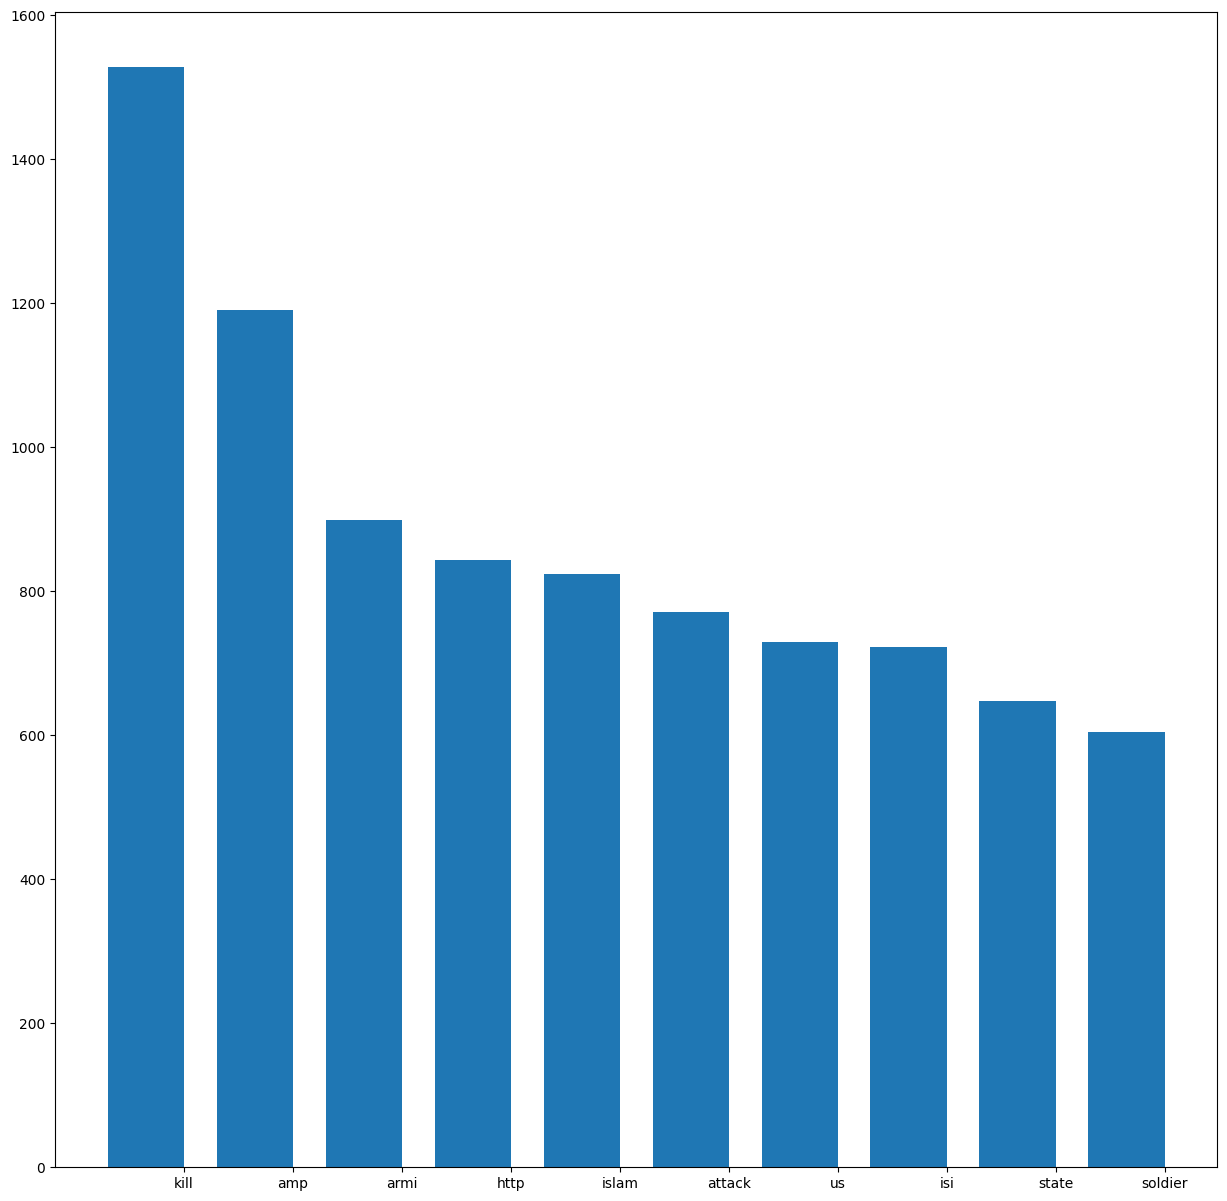

In [40]:
import operator
wordcount = sorted(wordcount.items(), key = operator.itemgetter(1))
wordcount.reverse()

import matplotlib.pyplot as plt

wordcount = wordcount[2:]
top10 = wordcount[:10]
top10_words = [word for (word,count) in top10]
top10_freq = [count for (word,count) in top10]
indexes = np.arange(len(top10_words))
width = 0.7
plt.figure(figsize=(15,15))
plt.bar(indexes, top10_freq, width)
plt.xticks(indexes + width/2 , top10_words)
plt.show()

In [41]:

unique_locations = tweets['location'].unique()
unique_counts = dict([(loc,list(tweets['location']).count(loc)) for loc in unique_locations])
unique_counts = sorted(unique_counts.items(),key = operator.itemgetter(1))
unique_counts.reverse()
for (loc,counts) in unique_counts:
    print(loc,counts)

nan 5978
Read my blog 1475
world 1191
Worldwide contributions 998
Texas, USA 993
اُمتِ مُسلمہ ولایت کشمیر 709
United States 587
28th Street, Qamar Precint 426
Germany 397
Dunya 366
Male'. Maldives. 333
S.Wazirstan|Mahsud not a Wazir 318
Middle of Nowhere 303
dar al-kufr 285
Nowhere 234
Wilayah Kashmir 231
München, Deutschland 193
Bandar Seri Begawan, Negara Brunei Darussalam 182
Geneva, Switzerland 166
Ghurabā 159
Among The Muslims 152
Gaziantep, Turkey 146
Wilayat Hadramaut 134
Singaparna, Indonesia 100
أسير الدنيا 100
Antas, Bahia 99
Land of Allah 97
EU 97
Earth 96
Punch, Jammu And Kashmir 95
Among mushrikeen 93
Wilayah Twitter 89
Al-Battar Media Foundatiom 80
Lake City, GA 68
Guetto 58
I hate snitches 49
darl mushrequeen 47
Amsterdam, The Netherlands 45
خارج الخلافة 42
Don't need to know 40
England, United Kingdom 27
AP 25
سرت‎ Sirte 23
40+Suspension for the truth! 23
noway 15
Dar Al Kufr 14
Islamic State 14
yamin, yasār raqum ١٤ 10
Prison ( Darul Kufr ) 4
. 4


In [42]:


def tweet_subject(tweet):
    tweet = re.sub('ENGLISH TRANSLATION:','',tweet)
    tweet = re.sub('ENGLISH TRANSLATIONS:','',tweet)
    tokenized = nltk.word_tokenize(tweet.lower())
    tagged = nltk.pos_tag(tokenized)
    nouns = [(word) for (word,tag) in tagged if re.match(r'NN',tag)!=None]
    return nouns
tweets['tweet_subjects'] = [tweet_subject(tweet) for tweet in tweets['tweets']]

all_subjects = [word for wordlist in tweets['tweet_subjects'] for word in wordlist]
all_subjects_counts =dict([(word,all_subjects.count(word)) for word in set(all_subjects) ])
all_subjects_counts = sorted(all_subjects_counts.items(), key = operator.itemgetter(1))
all_subjects_counts.reverse()
print('TOTAL UNIQUE SUBJECTS : ', len(all_subjects_counts))
for (a,b) in all_subjects_counts[:30]:
    print(a,b)


TOTAL UNIQUE SUBJECTS :  28585
https 9224
@ 7497
rt 5841
isis 2340
amp 1312
syria 1077
army 903
.. 819
state 706
i 615
today 569
ramiallolah 567
soldiers 525
forces 486
city 472
people 432
attack 424
aleppo 410
assad 379
fighters 361
iraq 352
rebels 347
… 343
amaqagency 336
allah 328
video 323
al 322
nidalgazaui 312
muslims 306
regime 303


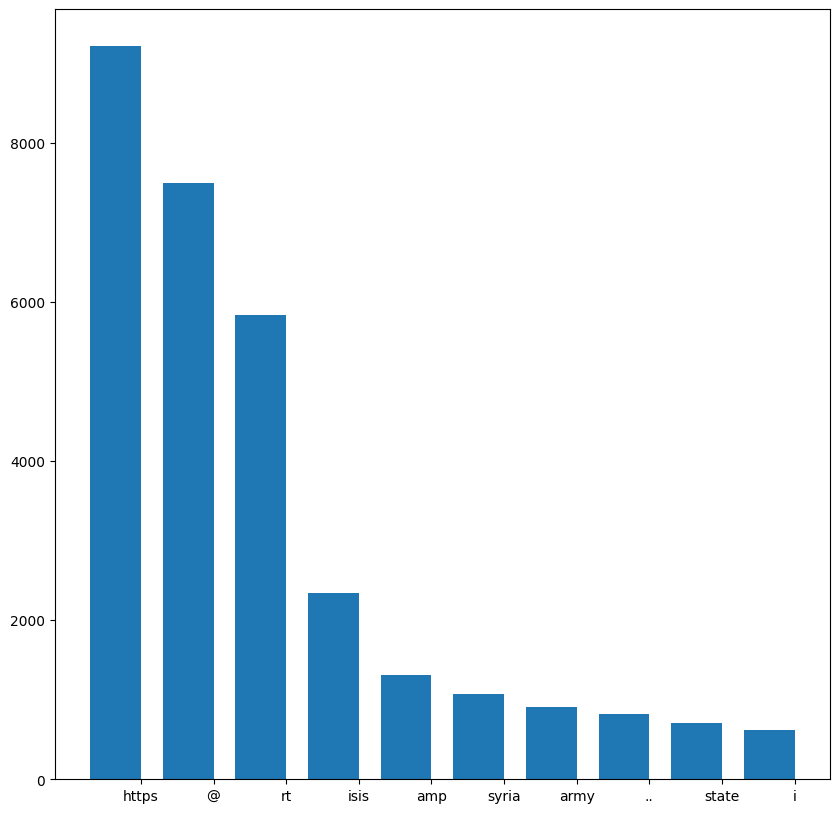

In [43]:
top10_sub = all_subjects_counts[:10]
top10_words = [word for (word,count) in top10_sub]
top10_freq = [count for (word,count) in top10_sub]
indexes = np.arange(len(top10_words))
width = 0.7
plt.figure(figsize=(10,10))
plt.bar(indexes, top10_freq, width)
plt.xticks(indexes + width/2 , top10_words)
plt.show()